# Computer Vision 
## Project -1
### Alok Sawant


Firstly, let's select TensorFlow version 2.x in colab

In [11]:
#%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [12]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


## Import dataset

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
# Image processing
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import skimage.io
import skimage.transform
from imageio import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from keras.layers.normalization import BatchNormalization 
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

print(os.listdir('../CNN/input/'))
directory=os.listdir('../CNN/input/')
# Any results you write to the current directory are saved as output

['.DS_Store', 'test', 'train']


In [14]:
import os
os.listdir("../CNN/input/")

['.DS_Store', 'test', 'train']

In [15]:
def get_images(directory):
    Images = []
    Labels = []
    for dir_name in os.listdir(directory): 
        for image_file in os.listdir(directory+dir_name):
            image = cv2.imread(directory+dir_name+r'/'+image_file)
            if image is not None:
                image = cv2.resize(image,(300,300),)
                Images.append(image)
                Labels.append(dir_name)
    return Images, Labels

In [22]:
Images, Labels = get_images('../CNN/input/train/')

In [28]:
Labels = []
mapping = { 'Sugar beet': 0, 'Fat Hen': 1, 'Scentless Mayweed' : 2, 'Charlock' : 3,
           'Small-flowered Cranesbill': 4, 'Maize': 5, 'Shepherds Purse' :6, 'Common wheat': 7,
           'Common Chickweed': 8, 'Cleavers': 9, 'Loose Silky-bent' : 10, 'Black-grass': 11 }
for label in Labels:
    labels.append(mapping[label])
del Labels

In [29]:
Images[0].shape

(300, 300, 3)

In [31]:
Images = np.reshape(Images,(-1,300,300,3))
Labels = np.array(labels)

In [32]:
print("Shape of training data: ", Images.shape)
print("Shape of labels data: ", Labels.shape)

Shape of training data:  (4750, 300, 300, 3)
Shape of labels data:  (4750,)


In [33]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Images, Labels, test_size=.2, random_state=42, stratify = Labels)

In [34]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,num_classes=12)
y_val = np_utils.to_categorical(y_val,num_classes=12)

In [35]:
train_datagen = ImageDataGenerator(
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                  )

validation_datagen = ImageDataGenerator()

In [36]:
del Images
del Labels

In [37]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(x_val, y_val, batch_size=16)

In [38]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(include_top=
            False, weights='imagenet', input_shape = (300,300,3))


In [39]:
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAvgPool2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model

In [40]:
vgg.trainable=False
for layer in vgg.layers:
    layer.trainable = False

fc1 = Concatenate(axis=-1)([GlobalAvgPool2D()(vgg.output), GlobalMaxPooling2D()(vgg.output)])
fc1 = Dense(400, activation='relu')(fc1)
fc1_dropout = Dropout(0.3)(fc1)
fc2 = Dense(200, activation='relu')(fc1_dropout)
fc2_dropout = Dropout(0.3)(fc2)
fc2 = Dense(75, activation='relu')(fc1_dropout)
output = Dense(12, activation='softmax')(fc2_dropout)
model = Model(vgg.input, output)

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('saved_model.hdf5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
trained = model.fit_generator(train_generator,steps_per_epoch = 25, epochs=200, validation_data = validation_generator,
                              validation_steps=10, 
                              verbose=1, callbacks = callbacks_list)

/Users/Alok/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
25/25 [==============================] - 180s 7s/step - loss: 26.9272 - accuracy: 0.0616 - val_loss: 8.2280 - val_accuracy: 0.1125

Epoch 00001: val_loss improved from inf to 8.22804, saving model to saved_model.hdf5
Epoch 2/200
25/25 [==============================] - 175s 7s/step - loss: 12.1823 - accuracy: 0.1395 - val_loss: 5.5918 - val_accuracy: 0.1625

Epoch 00002: val_loss improved from 8.22804 to 5.59178, saving model to saved_model.hdf5
Epoch 3/200
25/25 [==============================] - 177s 7s/step - loss: 9.4071 - accuracy: 0.1608 - val_loss: 4.3476 - val_accuracy: 0.1813

Epoch 00003: val_loss improved from 5.59178 to 4.34760, saving model to saved_model.hdf5
Epoch 4/200
25/25 [==============================] - 176s 7s/step - loss: 8.0704 - accuracy: 0.1347 - val_loss: 4.3016 - val_accuracy: 0.1937

Epoch 00004: val_loss improved from 4.34760 to 4.30155, saving model to saved_model.hdf5
Epoch 5/200
25/25 [==============================] - 174s 7s/step - loss: 

Epoch 39/200
25/25 [==============================] - 192s 8s/step - loss: 2.0567 - accuracy: 0.3430 - val_loss: 1.4495 - val_accuracy: 0.5188

Epoch 00039: val_loss improved from 1.48912 to 1.44945, saving model to saved_model.hdf5
Epoch 40/200
25/25 [==============================] - 194s 8s/step - loss: 2.0548 - accuracy: 0.3346 - val_loss: 1.6256 - val_accuracy: 0.4750

Epoch 00040: val_loss did not improve from 1.44945
Epoch 41/200
25/25 [==============================] - 195s 8s/step - loss: 2.0801 - accuracy: 0.3760 - val_loss: 1.4499 - val_accuracy: 0.5250

Epoch 00041: val_loss did not improve from 1.44945
Epoch 42/200
25/25 [==============================] - 193s 8s/step - loss: 1.9585 - accuracy: 0.3777 - val_loss: 1.4589 - val_accuracy: 0.5125

Epoch 00042: val_loss did not improve from 1.44945
Epoch 43/200
25/25 [==============================] - 192s 8s/step - loss: 2.0534 - accuracy: 0.3625 - val_loss: 1.4196 - val_accuracy: 0.5625

Epoch 00043: val_loss improved from 1.

25/25 [==============================] - 175s 7s/step - loss: 1.1553 - accuracy: 0.6209 - val_loss: 0.6221 - val_accuracy: 0.8000

Epoch 00119: val_loss improved from 0.75051 to 0.62214, saving model to saved_model.hdf5
Epoch 120/200
25/25 [==============================] - 175s 7s/step - loss: 1.2183 - accuracy: 0.6065 - val_loss: 0.9361 - val_accuracy: 0.6812

Epoch 00120: val_loss did not improve from 0.62214
Epoch 121/200
25/25 [==============================] - 173s 7s/step - loss: 1.1239 - accuracy: 0.6179 - val_loss: 0.8230 - val_accuracy: 0.6938

Epoch 00121: val_loss did not improve from 0.62214
Epoch 122/200
25/25 [==============================] - 177s 7s/step - loss: 1.1571 - accuracy: 0.6088 - val_loss: 0.9340 - val_accuracy: 0.7063

Epoch 00122: val_loss did not improve from 0.62214
Epoch 123/200
25/25 [==============================] - 174s 7s/step - loss: 1.1407 - accuracy: 0.6116 - val_loss: 0.8048 - val_accuracy: 0.7125

Epoch 00123: val_loss did not improve from 0.62

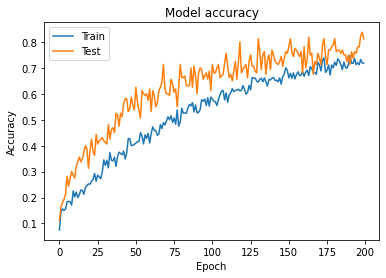

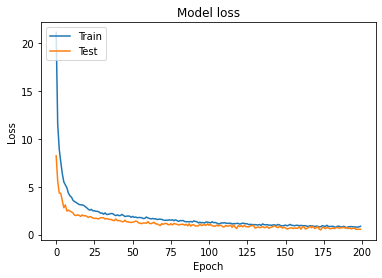

In [45]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
def get_test_images(directory):
    Images = []
    Image_names = []
    for image_file in os.listdir(directory):
        Image_names.append(image_file)
        image = cv2.imread(directory+r'/'+image_file)
        if image is not None:
            image = cv2.resize(image,(300,300),)
            Images.append(image)
    return Images, Image_names

In [48]:
test_images, image_names = get_test_images('../CNN/input/test/')
test_images = np.array(test_images)
print(test_images.shape)

(794, 300, 300, 3)


In [49]:
vgg = VGG16(include_top=
            False, weights='imagenet', input_shape = (300,300,3))

vgg.trainable=False
for layer in vgg.layers:
    layer.trainable = False

fc1 = Concatenate(axis=-1)([GlobalAvgPool2D()(vgg.output), GlobalMaxPooling2D()(vgg.output)])
fc1 = Dense(400, activation='relu')(fc1)
fc1_dropout = Dropout(0.3)(fc1)
fc2 = Dense(200, activation='relu')(fc1_dropout)
fc2_dropout = Dropout(0.3)(fc2)
fc2 = Dense(75, activation='relu')(fc1_dropout)
output = Dense(12, activation='softmax')(fc2_dropout)
model = Model(vgg.input, output)

In [50]:
model.load_weights('saved_model.hdf5')

In [51]:
tensorflow.keras.models.save_model(
    model,
    'tf_model.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [52]:
from tensorflow.keras.models import load_model
model = load_model('tf_model.hdf5')

In [53]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis = 1)

In [ ]:
labelled_predictions = []
mapping = {0: 'Sugar beet',1:'Fat Hen' ,2: 'Scentless Mayweed',3:  'Charlock', 
        4:'Small-flowered Cranesbill', 5:'Maize' ,
        6: 'Shepherds Purse' ,7:'Common wheat' ,8:'Common Chickweed' ,
        9:'Cleavers' ,10:'Loose Silky-bent'  ,11: 'Black-grass'}
for pred in predictions:
    labelled_predictions.append(mapping[pred])

In [55]:
d = []
i=0
for pred in labelled_predictions:
    d.append({'file': image_names[i], 'species': pred})
    i=i+1
output = pd.DataFrame(d)
output.to_csv('submission.csv',index=False)